In [2]:
# Fill in your name using the format below and student ID number
your_name = "Kaidong, Wu"
student_id = "1457721"

In [3]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [4]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [5]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[]

In [6]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [7]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Wu, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = 'D:\\clone\\assignment-3-Fakak'

In [19]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [20]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [9]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [10]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [11]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

[0, 1]


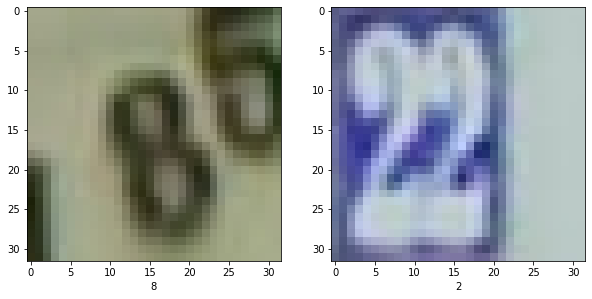

In [33]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

#images = [randint(0,len(X_test)) for i in range(5)]
images=[0,1]
print(images)
X_random = [X_test[i] for i in images]
#X_random = X_test[0]
y_random = [y_test[i] for i in images]
#y_random = y_test[0]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=496, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.170817  0.190592  2.164226      0.187827
max  2.243367  0.197595  2.198731      0.200667


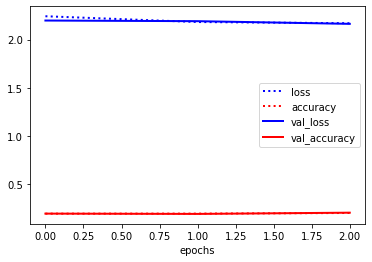

In [14]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=True, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.170817  0.190592  2.164226      0.187827
max  2.243367  0.197595  2.198731      0.200667


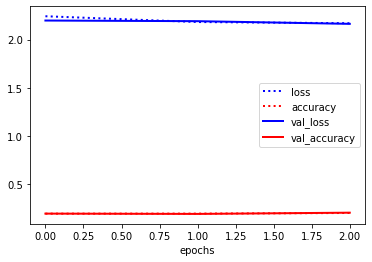

In [15]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 4s 58us/sample - loss: 2.2364 - accuracy: 0.1903 - val_loss: 2.1776 - val_accuracy: 0.2150
Epoch 2/50
63544/63544 [==============================] - 3s 46us/sample - loss: 2.0009 - accuracy: 0.2863 - val_loss: 1.8637 - val_accuracy: 0.3391
Epoch 3/50
63544/63544 [==============================] - 3s 49us/sample - loss: 1.7139 - accuracy: 0.4067 - val_loss: 1.6552 - val_accuracy: 0.4467
Epoch 4/50
63544/63544 [==============================] - 3s 48us/sample - loss: 1.5680 - accuracy: 0.4698 - val_loss: 1.5417 - val_accuracy: 0.4967
Epoch 5/50
63544/63544 [==============================] - 3s 44us/sample - loss: 1.4697 - accuracy: 0.5100 - val_loss: 1.3880 - val_accuracy: 0.5436
Epoch 6/50
63544/63544 [==============================] - 3s 44us/sample - loss: 1.3865 - accuracy: 0.5437 - val_loss: 1.3369 - val_accuracy: 0.5728
Epoch 7/50
63544/63544 [=============

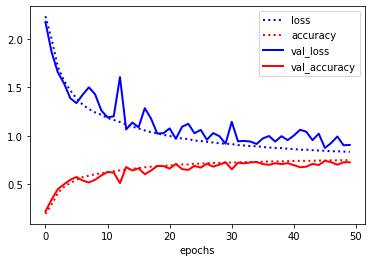

In [181]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=128)
answer_q_1_1 = """
  I built a neural network as the question description. The activation function of hidden layers are "relu", it is in most cases the default option, "softmax" is the activation function of output layer because the output values, can be seen as the "probability", thus ideal for classification problem.
  The model performs well without overfitting according to the plot.
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [17]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 4s 57us/sample - loss: 2.1440 - accuracy: 0.2267 - val_loss: 1.9503 - val_accuracy: 0.3191
Epoch 2/50
63544/63544 [==============================] - 3s 41us/sample - loss: 1.7552 - accuracy: 0.3943 - val_loss: 1.5791 - val_accuracy: 0.4701
Epoch 3/50
63544/63544 [==============================] - 3s 41us/sample - loss: 1.5578 - accuracy: 0.4709 - val_loss: 1.6486 - val_accuracy: 0.4446
Epoch 4/50
63544/63544 [==============================] - 3s 41us/sample - loss: 1.4197 - accuracy: 0.5338 - val_loss: 1.3466 - val_accuracy: 0.5659
Epoch 5/50
63544/63544 [==============================] - 3s 41us/sample - loss: 1.3115 - accuracy: 0.5776 - val_loss: 1.3519 - val_accuracy: 0.5576
Epoch 6/50
63544/63544 [==============================] - 3s 42us/sample - loss: 1.2351 - accuracy: 0.6070 - val_loss: 1.4064 - val_accuracy: 0.5425
Epoch 7/50
63544/63544 [=============

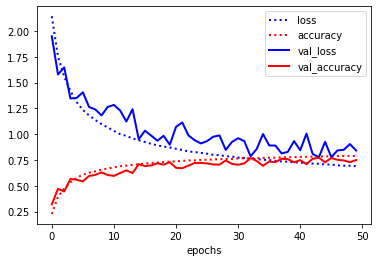

In [183]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=128)
answer_q_1_2 = """
    I convert the RGB images to greyscale and retrain the model. The input shape is (32,32,1) now, and needed to reshape to (1024,), other parameters are exactly the same as 1.1.
    The result shows that greyscale images has better performance than RGB images. This implies that the label of digits depends on its shapes, not colors. The color may even disturb performance. That's maybe because light may blur images and make it difficult for classification.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 7s 103us/sample - loss: 1.4881 - accuracy: 0.5260 - val_loss: 2.5886 - val_accuracy: 0.2852
Epoch 2/50
63544/63544 [==============================] - 4s 60us/sample - loss: 1.0726 - accuracy: 0.6711 - val_loss: 1.5001 - val_accuracy: 0.5320
Epoch 3/50
63544/63544 [==============================] - 4s 59us/sample - loss: 0.9503 - accuracy: 0.7083 - val_loss: 1.5867 - val_accuracy: 0.5240
Epoch 4/50
63544/63544 [==============================] - 4s 59us/sample - loss: 0.8819 - accuracy: 0.7297 - val_loss: 1.9533 - val_accuracy: 0.4471
Epoch 5/50
63544/63544 [==============================] - 4s 59us/sample - loss: 0.8420 - accuracy: 0.7446 - val_loss: 2.0881 - val_accuracy: 0.4527
Epoch 6/50
63544/63544 [==============================] - 4s 59us/sample - loss: 0.8121 - accuracy: 0.7533 - val_loss: 1.7321 - val_accuracy: 0.4793
Epoch 7/50
63544/63544 [============

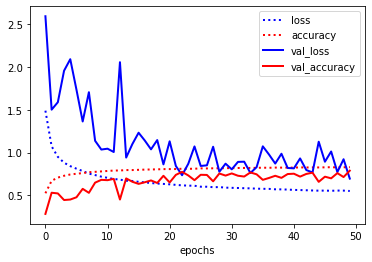

In [184]:
#from keras import regularizers

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=128)
answer_q_1_3 = """
               Since there are no overfitting occurs in 1.1 and 1.2, regularization methods like L1,L2 regularization and dropout do not help(I've tried those methods, they are indeed lower the performance a little). So I only use batch normalization, which increase the "capacity" of nerual network. The result shows that batch normalization increase val accuracy by 1%.
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 22s 345us/sample - loss: 1.8505 - accuracy: 0.4000 - val_loss: 0.6795 - val_accuracy: 0.7883
Epoch 2/50
63544/63544 [==============================] - 18s 283us/sample - loss: 0.6834 - accuracy: 0.7966 - val_loss: 0.6871 - val_accuracy: 0.8205
Epoch 3/50
63544/63544 [==============================] - 19s 292us/sample - loss: 0.4898 - accuracy: 0.8600 - val_loss: 0.3463 - val_accuracy: 0.8982
Epoch 4/50
63544/63544 [==============================] - 19s 299us/sample - loss: 0.4099 - accuracy: 0.8837 - val_loss: 0.3578 - val_accuracy: 0.8916
Epoch 5/50
63544/63544 [==============================] - 19s 304us/sample - loss: 0.3632 - accuracy: 0.8996 - val_loss: 0.3425 - val_accuracy: 0.9037
Epoch 6/50
63544/63544 [==============================] - 20s 310us/sample - loss: 0.3279 - accuracy: 0.9095 - val_loss: 0.2530 - val_accuracy: 0.9274
Epoch 7/50
63544/63544 [=

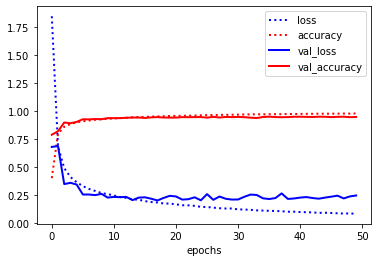

In [185]:
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val


def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))  
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=50, batch_size=128)
answer_q_2_1 = """
               I construct a VGG-like model(I remove a maxpooling layer for the size reason), at first setting, the model overfits begins from about 15 epochs.
               Then I use an common approach used in the lab that gradually increase the amount of dropout and add batchnormalizations after dense layer. The accuracy reachs 95% without overfitting.
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Training the model
  ...
    to  
  ['...']
Train for 496 steps, validate on 15887 samples
Epoch 1/50
496/496 [==============================] - 32s 64ms/step - loss: 2.5807 - accuracy: 0.1396 - val_loss: 2.3302 - val_accuracy: 0.1918
Epoch 2/50
496/496 [==============================] - 30s 60ms/step - loss: 2.2539 - accuracy: 0.1877 - val_loss: 2.0961 - val_accuracy: 0.2506
Epoch 3/50
496/496 [==============================] - 30s 60ms/step - loss: 1.6770 - accuracy: 0.4253 - val_loss: 1.2632 - val_accuracy: 0.6760
Epoch 4/50
496/496 [==============================] - 30s 60ms/step - loss: 1.1216 - accuracy: 0.6422 - val_loss: 0.6063 - val_accuracy: 0.8263
Epoch 5/50
496/496 [==============================] - 30s 60ms/step - loss: 0.8958 - accuracy: 0.7225 - val_loss: 0.4168 - val_accuracy: 0.8732
Epoch 6/50
496/496 [==============================] - 30s 60ms/step - loss: 0.7538 - accuracy: 0.7723 - val_loss: 0.3888 - val_accuracy: 0.8819
Epoch 7/50
496/496 [=========================

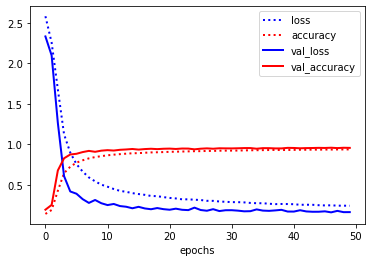

In [186]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    rotation_range=15)
it_train = train_datagen.flow(rgb2gray(X_train), y_train, batch_size=128)
augmented_split = it_train, rgb2gray(X_val), y_val


run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, epochs=50, batch_size=None ,generator=True)
answer_q_2_2 = """
               I've tried many combination of parameters, only a few of them improve performance. Some parameters even lower performance like shear=0.5. The idea is that we should make sure augmented data is reasonable in real life. (For example, we don’t often encounter horizontally flipped numbers)
               The parameters in the code that very subtle augment data imporves accuracy a little bit (less than 1%).
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/19858 [==============================] - 7s 357us/sample - loss: 0.1683 - accuracy: 0.9540
[0.16830583152451542, 0.95397323]


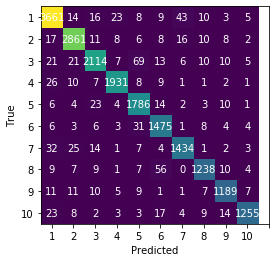

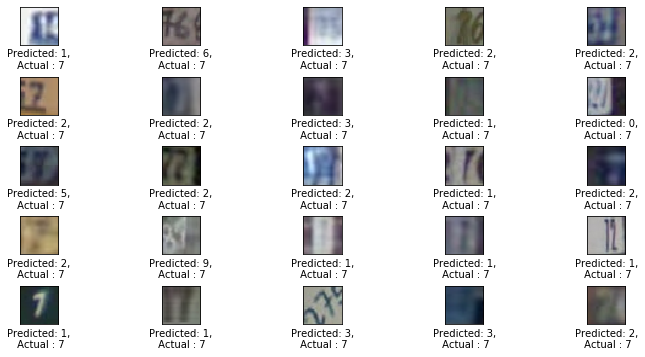

Answer is 472 characters long


In [30]:
from sklearn.metrics import confusion_matrix
import math
model = load_model_from_file(base_dir, "model_2_2" )
#acc = model.evaluate(rgb2gray(X_test), y_test)
#print(acc)

y_pred = model.predict(rgb2gray(X_test))
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
#print(misclassified_samples)

test_accuracy_3_1 = 0.954
def plot_confusion_matrix():
  cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
  fig, ax = plt.subplots()
  im = ax.imshow(cm)
  ax.set_xticks(np.arange(11)), ax.set_yticks(np.arange(10))
  ax.set_xticklabels(np.arange(1,11))
  ax.set_yticklabels(np.arange(1,11))
  ax.set_ylabel('True')
  ax.set_xlabel('Predicted')
  for i in range(100):
      ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")
def plot_misclassifications():
  fig, axes = plt.subplots(5, 5, figsize=(10,5))
  fig.tight_layout()
  n=0
  for nr, i in enumerate(misclassified_samples[:]):
    if np.argmax(y_test[i])+1 == 7:
      axes[math.floor(n/5),n%5].imshow(X_test[i])
      axes[math.floor(n/5),n%5].set_xlabel("Predicted: %s,\n Actual : %s" % ((np.argmax(y_pred[i])+1)%10,(np.argmax(y_test[i])+1)%10))
      axes[math.floor(n/5),n%5].set_xticks(()), axes[math.floor(n/5),n%5].set_yticks(())
      n+=1
      if n==25:
        break
  plt.show()

  
plot_confusion_matrix()
plot_misclassifications()

answer_q_3_1 = """
               As we can see in the confusion matrix, class 7 is often misclassified. So I plot 25 misclassified samples that have a actual label of 7 to see what kind of mistake are made. The main reason for misclassification is that some figures are too close in shape, like 1 and 7, even human makes this mistake. Also, there are other types of mistakes such as two or more figures appears together and the classifier is attracted by the other figure. 
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

Answer is 526 characters long


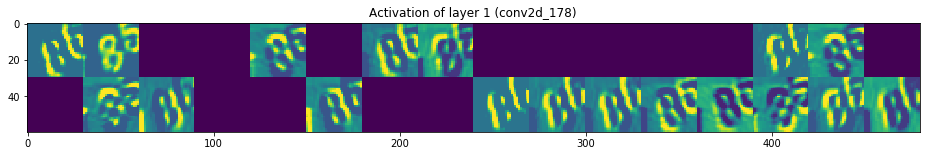

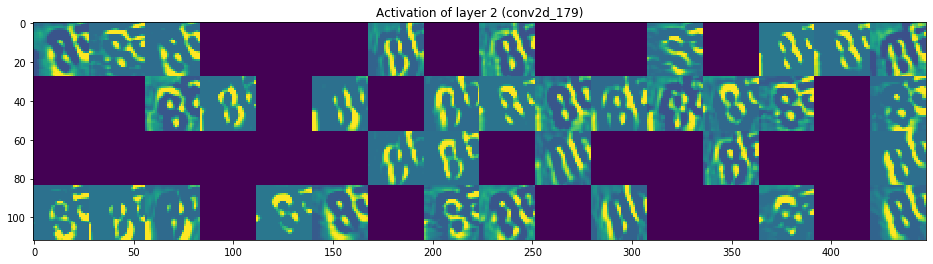

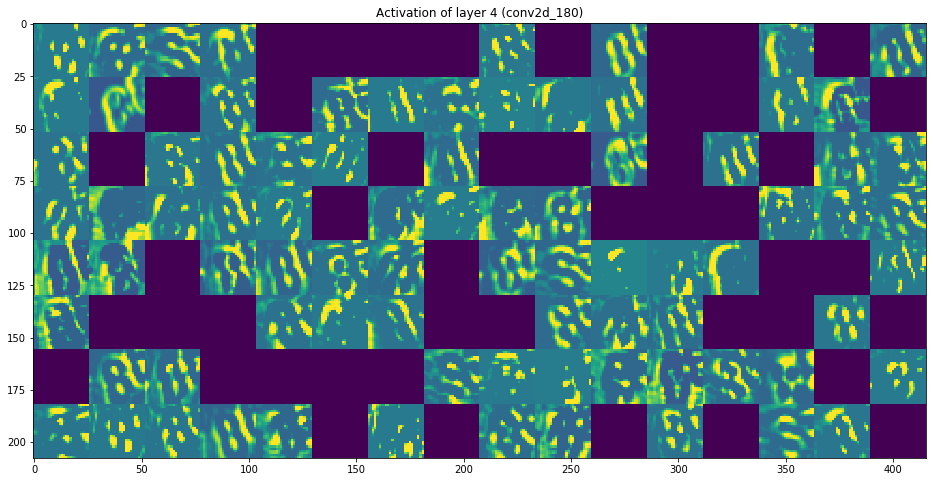

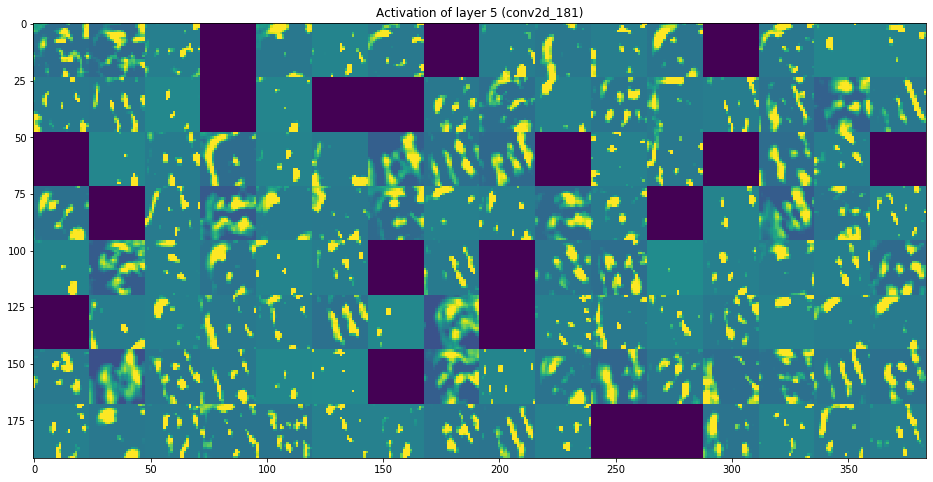

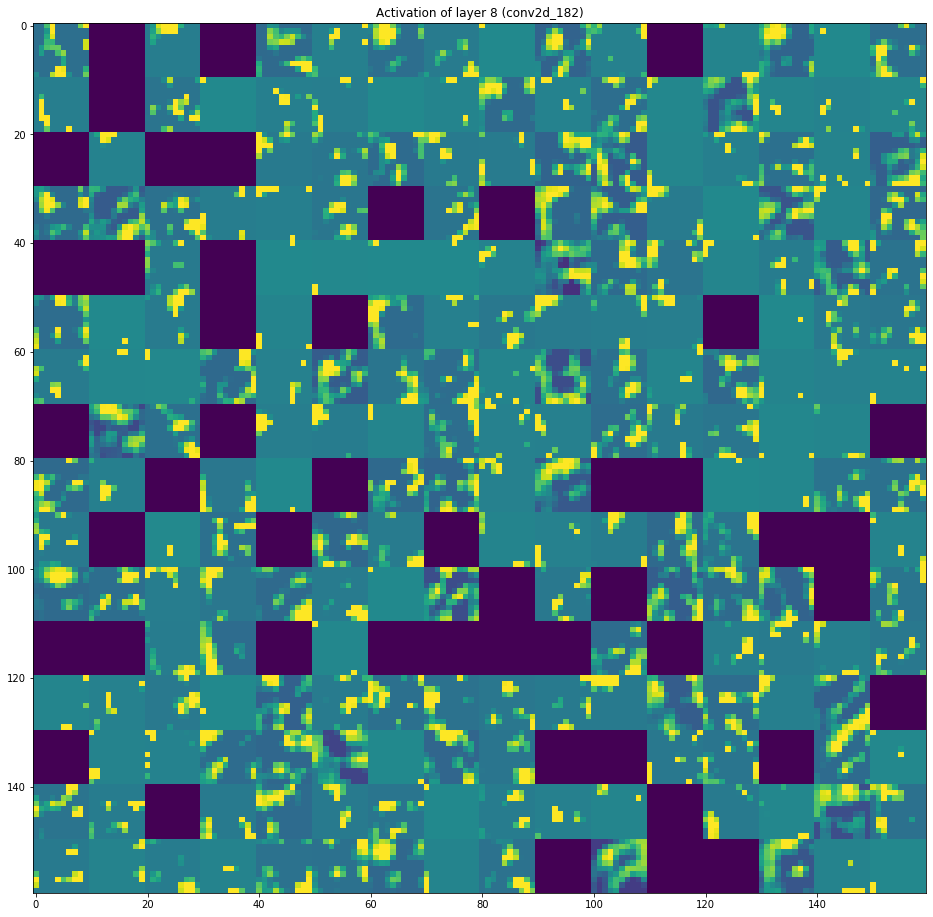

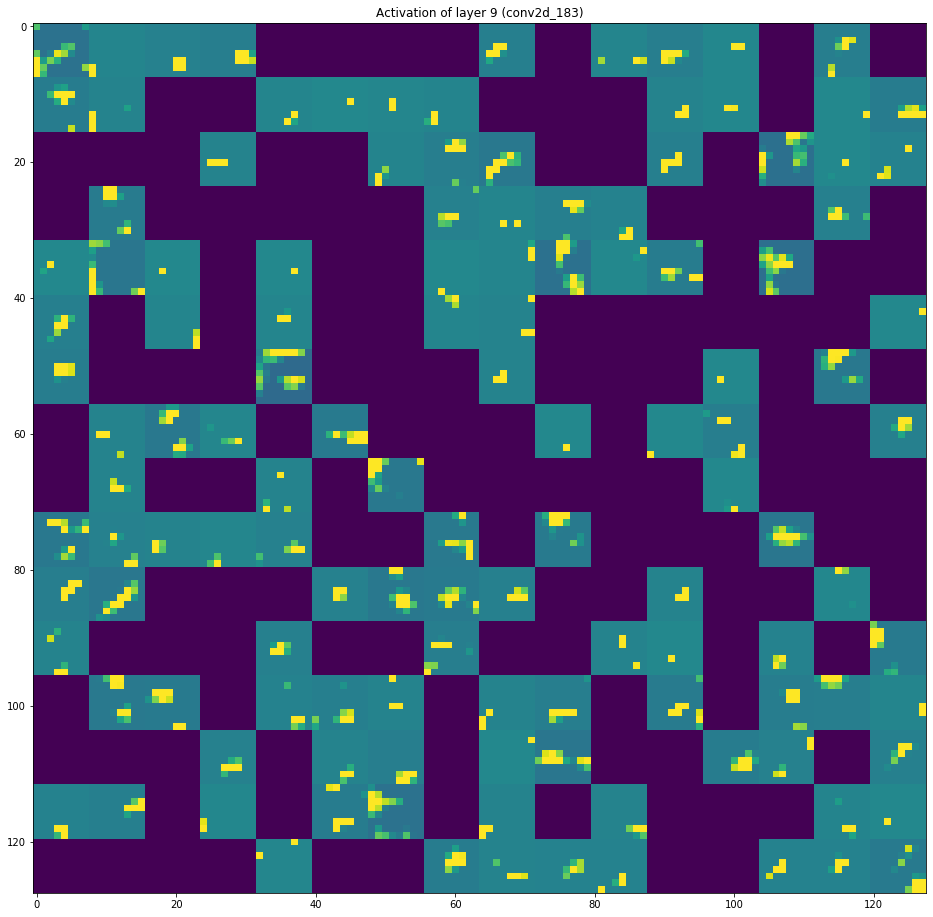

In [18]:
from tensorflow.keras import models

model = load_model_from_file(base_dir, "model_2_2" )
img_tensor = rgb2gray(X_test)[0]
img_tensor = np.expand_dims(img_tensor, axis=0) 
layer_outputs = [layer.output for layer in model.layers[:18]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
#print(activations)
images_per_row = 16
layer_names = []
for layer in model.layers[:18]:
    layer_names.append(layer.name)


def plot_activations():
    for i in [0,1,3,4,7,8]:
        start = i
        end = i+1
        for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                    :, :,
                                                    col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title("Activation of layer {} ({})".format(i+1,layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()
plot_activations()
answer_q_3_2 = """
               The activations of first layer keep the shape of original digits. There are about a half activations are left blank, this means no features are caputered by these filters.
               The activations become more abstract as we go deeper into the layers. This is because higher level layers begin to capture higher level features by combining lower level features. As we can see in the last several layers, the activations are mainly basic geometric elements such as curves, dots and lines.


               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

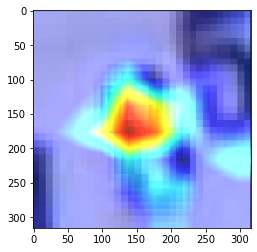

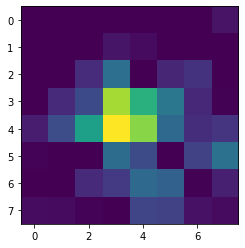

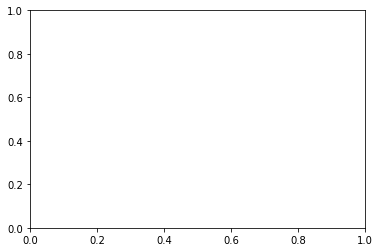

In [45]:
import cv2
from keras import backend as K
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
img_path = 'D:\\clone\\assignment-3-Fakak\\8.jpg'
superimposed = 'D:\\clone\\assignment-3-Fakak\\CAM.jpeg'
model = load_model_from_file(base_dir,"model_2_2")



def plot_3_3():
    #fig, axes = plt.subplots(1, 1,  figsize=(10, 5))
    img=Image.open(superimposed)
    npimg=np.array(img)
    plt.imshow(npimg)
    plt.show()
    plt.cla()


def plot_activation_map():
    #fig, axes = plt.subplots(1, 1,  figsize=(10, 5))
    x = rgb2gray(X_test)[0]
    x = np.expand_dims(x,axis=0)
    pred = model.predict(x)
    class_idx = np.argmax(pred[0])
    class_output = model.output[:,class_idx]
    last_conv_layer = model.layers[8]
    grads = K.gradients(class_output,last_conv_layer.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(256):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]           
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    plt.imshow(heatmap)
    plt.show()
    plt.cla() 
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = 0.8
    superimposed_img = heatmap * hif + img    
    cv2.imwrite(superimposed, superimposed_img)

plot_3_3()
plot_activation_map()



## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/50
63544/63544 [==============================] - 23s 366us/sample - loss: 1.5180 - accuracy: 0.4846 - val_loss: 1.2642 - val_accuracy: 0.5803
Epoch 2/50
63544/63544 [==============================] - 19s 297us/sample - loss: 1.1509 - accuracy: 0.6146 - val_loss: 1.0823 - val_accuracy: 0.6335
Epoch 3/50
63544/63544 [==============================] - 20s 310us/sample - loss: 1.0005 - accuracy: 0.6687 - val_loss: 0.9747 - val_accuracy: 0.6738
Epoch 4/50
63544/63544 [==============================] - 21s 325us/sample - loss: 0.9085 - accuracy: 0.6990 - val_loss: 0.9334 - val_accuracy: 0.6899
Epoch 5/50
63544/63544 [==============================] - 21s 332us/sample - loss: 0.8402 - accuracy: 0.7246 - val_loss: 0.8427 - val_accuracy: 0.7207
Epoch 6/50
63544/63544 [==============================] - 21s 335us/sample - loss: 0.7902 - accuracy: 0.7404 - val_loss: 0.8709 - val_accuracy: 0.7130
Epoch 7/50
63544/63544 [=

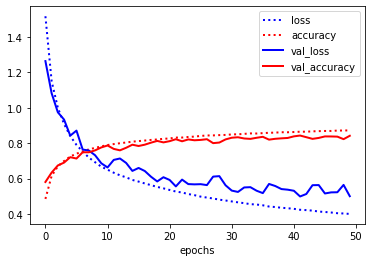

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16
con_layer_index = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

def build_model_4_1():
    model = models.Sequential()
    model.add(VGG16(include_top = False, weights = 'imagenet', input_shape=(32, 32, 3), pooling='max'))
    #model.summary()
    
    for i in con_layer_index[2:13]:    
        layer = model.layers[0].layers[i]
        layer.trainable = False
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop' ,loss='categorical_crossentropy',metrics=['accuracy'])
    return model
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=50, batch_size=128)

answer_q_4_1 = """
               The accuracy is approximately 65% if all convolution layers are freezed in vgg16. If we enable two convolutional layers(which is block 1),
               we get an accuracy 84.3%. Obviously, unfreeze convolutional layers makes performance better.
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))



### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [29]:
import pickle
import gzip

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

model = load_model_from_file(base_dir, "model_4_1")
#model.summary()
def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  vgg16_conv_layers = model.get_layer('vgg16')
  train = vgg16_conv_layers.predict(X_train_all)
  train = train.reshape(train.shape[0], 512)
  test = vgg16_conv_layers.predict(X_test)
  test = test.reshape(test.shape[0], 512)
  store_embedding(train, 'vgg16_train_all')
  store_embedding(test, 'vgg16_test')

def generate_pipeline():
  """ Returns an sklearn pipeline.
  """
#   clf = DecisionTreeClassifier(random_state=1)
#   return Pipeline(steps=[('classifier', clf)])
#   clf = svm.SVC(kernel = 'rbf', random_state=1)
  #clf = LogisticRegression(random_state=1)
  clf = RandomForestClassifier(random_state=1)
  return Pipeline(steps=[('classifier', clf)])


def evaluate_pipeline(pipeline, X_train_embeded, y_train, X_test_embeded, y_test):
  """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
  """
  #X_train_reshape = np.reshape(X_train,(np.shape(X_train)[0],np.shape(X_train)[1]*np.shape(X_train)[2]*np.shape(X_train)[3]))
  #X_test_reshape = np.reshape(X_test,(np.shape(X_test)[0],np.shape(X_test)[1]*np.shape(X_test)[2]*np.shape(X_test)[3]))
  X_train_embeded = X_train_embeded.reshape(X_train_embeded.shape[0], -1)
  X_test_embeded = X_test_embeded.reshape(X_test_embeded.shape[0], -1)
  pipeline.fit(X_train_embeded, y_train)
  return pipeline.score(X_test_embeded, y_test)

def evaluation_4_2(X_train_embeded, y_train, X_test_embeded, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  pipeline = generate_pipeline()
  score = evaluate_pipeline(pipeline, X_train_embeded, y_train.argmax(axis=1), X_test_embeded, y_test.argmax(axis=1))
  return score

store_embeddings()
embeded_train = load_embedding('vgg16_train_all')
embeded_test = load_embedding('vgg16_test')
score = evaluation_4_2(embeded_train, y_train_all, embeded_test, y_test)
#score = 0.533
#print("score:",score)


answer_q_4_2 = """
              I use randomforestrwithout scaler. The score is 0.70, which is far from the best model. That's may be because in 4.1, I only unfreeze 2 convolutional layers. If more(or all) con layers are unfreezed, the performance would be better. But it takes a lot of time to retrain the model, so I skip it. 
               """
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

(79431, 512)
(19858, 512)
score: 0.5334374055796153
Pipeline: Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False)
Answer is 327 characters long
